In [10]:
# Importing libraries
import numpy as np
import pandas as pd
import cantera as ct
import matplotlib.pyplot as plt
import json

# Importing packages
import feedstock as fs
import pp
import gasifier as g
import fuel as fu
import energy as en
import outputs as op

In [11]:
# Grabbing data from JSON file
with open('data/data.json','r') as dataFile:
    data = json.load(dataFile)
    dataFile.close()

In [12]:
# Table2 = data['Thamavithya2010']['Table2']
# df = pd.DataFrame(Table2)
# df.head()

In [13]:
# fuelID = "ThamaSawdust"
# species=['CO','H2','CH4','CO2','N2']
# moist = fu.moisture(fuelID)
# n = len(Table2)
# ER = np.array([run['ER'] for run in Table2])
# T = np.array([run['Tgas'] for run in Table2]) + 273.15 # K
# experimental = np.zeros((n, len(species)))
# for i in range(n):
#     for j, sp in enumerate(species):
#         experimental[i,j] = Table2[i][sp]/100
# CC = np.array([run['CarbonConv'] for run in Table2])

In [14]:
# predicted = np.zeros_like(experimental)
# for i in range(n):
#     report0 = g.gasifier(fuelID, moist=moist, T=T[i], air=ER[i], airType='ER', species=species)
#     CC_pred = report0['CC']
#     C_avail0 = CC[i]/CC_pred
#     DT, sqerr = g.findTquasi(fuelID, experimental[i], moist=moist, T0=T[i], air=ER[i], airType='ER', C_avail=1.0, species=species)
#     report1 = g.gasifier(fuelID, moist=moist, T=T[i]-DT, air=ER[i], airType='ER', species=species+['C(gr)'], C_avail=1.0)
#     for j, sp in enumerate(species):
#         predicted[i,j] = report1[sp]
#     print(i)
# print(predicted)

In [15]:
# plt.scatter(ER, experimental[:,4], label='CO')
# plt.plot(ER, predicted[:,4], label='CO pred')
# plt.grid()
# plt.show()

In [16]:
# This uses data from 10.1007/s11708-020-0710-3 (Guo et al., 2020)

# Fuel is already in database (Compressed Corn Straw)
fuelID = 'GuoCorn'

GuoDict = data["Guo2021"]["Table3"]

# Experimental data information
T = np.array([700, 800, 900]) # °C
T = T + 273.15 # K
ER = 0.21 # constant
moist = 0
species = ['CO2', 'CO', 'CH4', 'H2']
experimental = np.array([[17.1, 14.7, 6.36, 7.58],
                         [16.5, 16.4, 6.07, 7.97],
                         [15.7, 17.8, 5.60, 8.35]]) # %
experimental = experimental/100 # fraction

In [17]:
# Creating a range of values for smooth, continuos model response
Tl = np.linspace(T[0], T[-1], 100) # K
CO2l = np.zeros_like(Tl)
COl = np.zeros_like(Tl)
CH4l = np.zeros_like(Tl)
H2l = np.zeros_like(Tl)

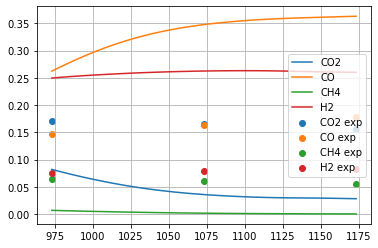

In [18]:
# First test: raw model, no modifications

for i, t in enumerate(Tl):
    report = g.gasifier(fuelID, T=t, air=ER, species=species)[0]
    CO2l[i] = report['CO2']
    COl[i] = report['CO']
    CH4l[i] = report['CH4']
    H2l[i] = report['H2']

plt.plot(Tl, CO2l, label='CO2')
plt.plot(Tl, COl, label='CO')
plt.plot(Tl, CH4l, label='CH4') 
plt.plot(Tl, H2l, label='H2')
plt.scatter(T, experimental[:,0], label='CO2 exp')
plt.scatter(T, experimental[:,1], label='CO exp')
plt.scatter(T, experimental[:,2], label='CH4 exp')
plt.scatter(T, experimental[:,3], label='H2 exp')
plt.legend()
plt.grid()
plt.savefig("results.png")
plt.show()

In [19]:
# Second test: modified model finds DT but not C_avail, uses average DT value

predicted = np.zeros_like(experimental)
DTsum = 0
for i, t in enumerate(T):
    Tquasi, sqerr = g.findTquasi(fuelID, experimental[i], T0=t, air=ER, species=species, C_avail=1.0)
    report = g.gasifier(fuelID, T=Tquasi, air=ER, species=species, C_avail=1.0)[0]
    for j, sp in enumerate(species):
        predicted[i,j] = report[sp]
    DT = t - Tquasi
    DTsum += DT
    print(DT, sqerr)

DTav = DTsum/len(T)
print(DTav)

for i, t in enumerate(Tl):
    report = g.gasifier(fuelID, T=t-DTav, air=ER, species=species)
    CO2l[i] = report['CO2']
    COl[i] = report['CO']
    CH4l[i] = report['CH4']
    H2l[i] = report['H2']

plt.plot(Tl, CO2l, label='CO2')
plt.plot(Tl, COl, label='CO')
plt.plot(Tl, CH4l, label='CH4') 
plt.plot(Tl, H2l, label='H2')
plt.scatter(T, experimental[:,0], label='CO2 exp')
plt.scatter(T, experimental[:,1], label='CO exp')
plt.scatter(T, experimental[:,2], label='CH4 exp')
plt.scatter(T, experimental[:,3], label='H2 exp')
plt.grid()
plt.legend()
plt.savefig("results2.png")
plt.show()

TypeError: gasifier() got an unexpected keyword argument 'mass'

In [ ]:
# # Third test: modified model finds DT and C_avail, uses average values

# predicted = np.zeros_like(experimental)
# sums = [0, 0]
# for i, t in enumerate(T):
#     X = g.findParams(fuelID, experimental[i], T0=t, air=ER, species=species)
#     DT, C_avail, sqerr = X
#     report = g.gasifier(fuelID, T=t-DT, air=ER, species=species, C_avail=C_avail)
#     for j, sp in enumerate(species):
#         predicted[i,j] = report[sp]
#     sums[0] += DT
#     sums[1] += C_avail
#     print(DT, C_avail, sqerr)
# DTav = sums[0]/len(T)
# C_avail_av = sums[1]/len(T)
# print(DTav, C_avail_av)

# for i, t in enumerate(Tl):
#     report = g.gasifier(fuelID, T=t-DTav, air=ER, species=species, C_avail=C_avail_av)
#     CO2l[i] = report['CO2']
#     COl[i] = report['CO']
#     CH4l[i] = report['CH4']
#     H2l[i] = report['H2']

# plt.plot(Tl, CO2l, label='CO2')
# plt.plot(Tl, COl, label='CO')
# plt.plot(Tl, CH4l, label='CH4') 
# plt.plot(Tl, H2l, label='H2')
# plt.scatter(T, experimental[:,0], label='CO2 exp')
# plt.scatter(T, experimental[:,1], label='CO exp')
# plt.scatter(T, experimental[:,2], label='CH4 exp')
# plt.scatter(T, experimental[:,3], label='H2 exp')
# plt.grid()
# plt.legend()
# plt.savefig("results3.png")
# plt.show()

In [ ]:
GuoDF = pd.DataFrame.from_dict(GuoDict)

n = len(GuoDict)
T = np.zeros(n)
ER = np.zeros(n)
SB = np.zeros(n)
DMP = np.zeros(n)
species = ['CO2', 'CO', 'CH4', 'H2']
experimental = np.zeros((n, len(species)))
for i, run in enumerate(GuoDict):
    T[i] = run['T']+273.15
    ER[i] = run['ER']
    SB[i] = run['S/B']
    DMP[i] = run['DMP']
    for j, sp in enumerate(species):
        experimental[i,j] = run[sp]/100
GuoDF.head()

,Run,T,ER,S/B,DMP,CO2,CO,CH4,H2,Tar
0,1,700,0.21,0.0,0,17.1,14.7,6.36,7.58,6.20
1,2,740,0.26,0.0,0,17.8,15.5,7.24,7.93,5.56
2,3,770,0.31,0.0,0,18.8,16.4,7.89,8.91,4.69
3,4,820,0.34,0.0,0,20.2,15.2,6.41,8.07,3.97
4,5,700,0.21,0.2,0,17.8,12.9,4.21,9.51,5.34


In [ ]:
predicted = np.zeros_like(experimental)
for i, run in enumerate(GuoDict):
    report0 = g.gasifier(fuelID, T=T[i], air=ER[i], airType='ER', stm=SB[i], stmType='steam', species=species, C_avail=1.0)
    sqErr = 0
    for j, sp in enumerate(species):
        predicted[i,j] = report0[sp]
        sqErr += (predicted[i,j]*100 - experimental[i,j]*100)**2
    RMSE = np.sqrt(sqErr/len(species)) # as a percentage
    print(i, RMSE)

0 11.692868007481986
1 12.085214392708087
2 10.450420263796453
3 10.184262747647635
4 11.847974150009902
5 9.975477012115704
6 9.058444380432995
7 11.092207529827371
8 10.219409995836983
9 9.845857333501474
10 14.783148561297805
11 14.596321372633264


In [ ]:
predicted = np.zeros_like(experimental)
DTav = 0
for i, run in enumerate(GuoDict):
    Tquasi, sqerr = g.findTquasi(fuelID, experimental[i], T0=T[i], air=ER[i], airType='ER', stm=SB[i], stmType='steam', species=species, C_avail=1.0)
    report1 = g.gasifier(fuelID, T=Tquasi, air=ER[i], airType='ER', stm=SB[i], stmType='steam', species=species, C_avail=1.0)[0]
    sqErr = 0
    for j, sp in enumerate(species):
        predicted[i,j] = report1[sp]
        sqErr += (predicted[i,j]*100 - experimental[i,j]*100)**2
    RMSE = np.sqrt(sqErr/len(species)) # as a percentage
    DTav += T[i] - Tquasi
    print(i, Tquasi - T[i], RMSE)
DTav /= len(T)
print(DTav)

0 -162.0765862991649 6.815220167272649
1 -157.56781279144457 6.497014246255699
2 -169.89243030705723 6.124447513985919
3 -231.68732723667176 5.744900663415262
4 -212.4677529205162 5.907703903505015
5 -182.12776667126445 4.992208542342307
6 -184.99852269518647 4.505880568725619
7 -127.9574563927581 6.743037819810104
8 -103.7769871200901 6.485726250082079
9 -97.2396264144976 6.212227960635342
10 -219.15923424444384 7.1528484519706765
11 -298.35883086071556 7.2610264810515375
178.94252782948422


In [ ]:
predicted = np.zeros_like(experimental)
for i, run in enumerate(GuoDict):
    report0 = g.gasifier(fuelID, T=T[i]-DTav, air=ER[i], airType='ER', stm=SB[i], stmType='steam', species=species, C_avail=1.0)
    sqErr = 0
    for j, sp in enumerate(species):
        predicted[i,j] = report0[sp]
        sqErr += (predicted[i,j]*100 - experimental[i,j]*100)**2
    RMSE = np.sqrt(sqErr/len(species)) # as a percentage
    print(i, RMSE)

0 6.82498651052924
1 6.574538482256658
2 6.1504116305526955
3 6.7587231338343745
4 6.018210079744731
5 4.994426677159007
6 4.518475685863215
7 6.9523627481933294
8 7.2911723269267
9 7.381549649336775
10 7.528468253404719
11 11.416062357519607
